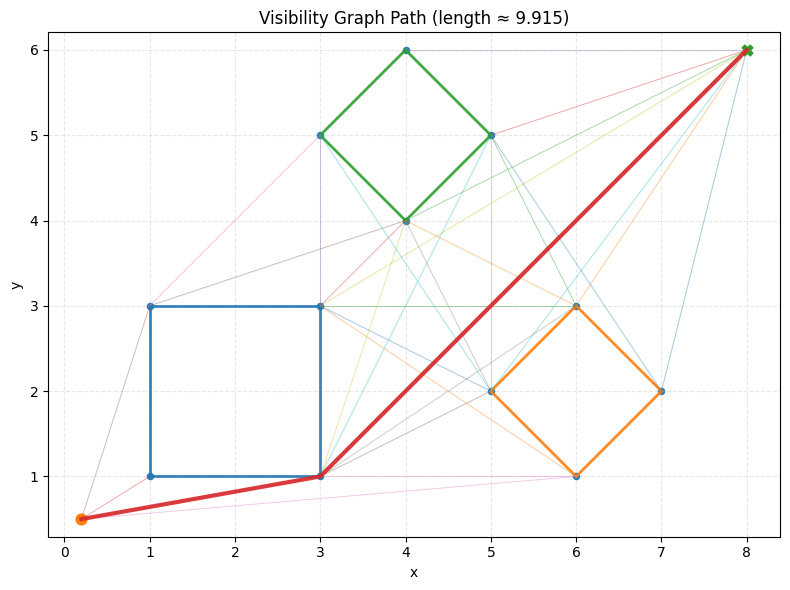

In [ ]:
# Toy example: visibility-graph path planning.
# It draws polygonal obstacles, builds a visibility graph (free-space edges),
# computes a shortest path with Dijkstra, and plots obstacles, graph, and final path.
#
# Notes:
# - No external libraries beyond the standard scientific stack.
# - We avoid specifying any explicit colors to comply with the UI rules.
# - This is a deterministic illustration (no chance constraints here);
#   it mirrors the "graph + shortest path + fix-path" spirit of HISA at a toy scale.

import math
import heapq
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

Point = Tuple[float, float]
Polygon = List[Point]

# ----------------------------
# Geometry utilities
# ----------------------------

EPS = 1e-9

def almost_equal(a: float, b: float, eps: float = EPS) -> bool:
    return abs(a - b) <= eps

def orient(a: Point, b: Point, c: Point) -> float:
    """Orientation / cross product sign of (b - a) x (c - a)."""
    return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])

def on_segment(a: Point, b: Point, c: Point) -> bool:
    """Check if point b lies on segment ac (assuming collinearity)."""
    return (min(a[0], c[0]) - EPS <= b[0] <= max(a[0], c[0]) + EPS and
            min(a[1], c[1]) - EPS <= b[1] <= max(a[1], c[1]) + EPS)

def points_equal(p: Point, q: Point, eps: float = EPS) -> bool:
    return almost_equal(p[0], q[0], eps) and almost_equal(p[1], q[1], eps)

def segments_intersect_strict(p1: Point, p2: Point, q1: Point, q2: Point) -> bool:
    """
    Proper intersection test: returns True if the interior of (p1,p2) intersects the interior of (q1,q2).
    Intersections only at shared endpoints are NOT considered blocking (visibility is allowed to touch vertices).
    """
    # Fast reject if any shared endpoints
    if points_equal(p1, q1) or points_equal(p1, q2) or points_equal(p2, q1) or points_equal(p2, q2):
        return False

    o1 = orient(p1, p2, q1)
    o2 = orient(p1, p2, q2)
    o3 = orient(q1, q2, p1)
    o4 = orient(q1, q2, p2)

    # General case: proper intersection
    if (o1 * o2 < 0) and (o3 * o4 < 0):
        return True

    # Collinear cases: if overlap at interior points (not endpoints)
    if almost_equal(o1, 0) and on_segment(p1, q1, p2):
        # Ensure q1 is not exactly at endpoints (already handled)
        if not (points_equal(q1, p1) or points_equal(q1, p2) or points_equal(q1, q2)):
            return True
    if almost_equal(o2, 0) and on_segment(p1, q2, p2):
        if not (points_equal(q2, p1) or points_equal(q2, p2) or points_equal(q1, q2)):
            return True
    if almost_equal(o3, 0) and on_segment(q1, p1, q2):
        if not (points_equal(p1, q1) or points_equal(p1, q2) or points_equal(p1, p2)):
            return True
    if almost_equal(o4, 0) and on_segment(q1, p2, q2):
        if not (points_equal(p2, q1) or points_equal(p2, q2) or points_equal(p1, p2)):
            return True

    return False

def point_in_polygon(pt: Point, poly: Polygon) -> bool:
    """Ray casting algorithm. True if pt is strictly inside; boundary treated as inside."""
    x, y = pt
    inside = False
    n = len(poly)
    for i in range(n):
        x1, y1 = poly[i]
        x2, y2 = poly[(i + 1) % n]
        # Check if the edge crosses the horizontal ray to the right of pt
        if ((y1 <= y < y2) or (y2 <= y < y1)):
            x_intersect = x1 + (y - y1) * (x2 - x1) / (y2 - y1 + 1e-20)
            if x_intersect >= x - EPS:
                inside = not inside
        # If exactly on an edge
        if almost_equal(orient((x1, y1), (x2, y2), (x, y)), 0) and on_segment((x1, y1), (x, y), (x2, y2)):
            return True
    return inside

def segment_is_free(p: Point, q: Point, obstacles: List[Polygon]) -> bool:
    """Segment pq is free if it does not cross interiors of any obstacles (touching vertices allowed)."""
    mid = ((p[0] + q[0]) * 0.5, (p[1] + q[1]) * 0.5)
    for poly in obstacles:
        # If midpoint lies inside polygon -> segment goes through the obstacle
        if point_in_polygon(mid, poly):
            return False
        # Check intersection with each polygon edge
        m = len(poly)
        for i in range(m):
            a = poly[i]
            b = poly[(i + 1) % m]
            if segments_intersect_strict(p, q, a, b):
                return False
    return True

# ----------------------------
# Visibility graph construction
# ----------------------------

def build_visibility_graph(start: Point, goal: Point, obstacles: List[Polygon], include_vertices=True):
    """Returns (nodes, edges) where nodes is list of points and edges is list of (i,j,dist)."""
    nodes: List[Point] = [start, goal]
    if include_vertices:
        for poly in obstacles:
            nodes.extend(poly)
    # Deduplicate nodes
    unique_nodes = []
    for p in nodes:
        if not any(points_equal(p, q) for q in unique_nodes):
            unique_nodes.append(p)
    nodes = unique_nodes

    edges = []
    n = len(nodes)
    for i in range(n):
        for j in range(i + 1, n):
            p, q = nodes[i], nodes[j]
            if segment_is_free(p, q, obstacles):
                dist = math.hypot(p[0] - q[0], p[1] - q[1])
                edges.append((i, j, dist))
    return nodes, edges

def dijkstra(nodes: List[Point], edges: List[Tuple[int, int, float]], src: int, dst: int):
    adj = [[] for _ in range(len(nodes))]
    for i, j, w in edges:
        adj[i].append((j, w))
        adj[j].append((i, w))
    dist = [math.inf] * len(nodes)
    prev = [-1] * len(nodes)
    dist[src] = 0.0
    pq = [(0.0, src)]
    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]:
            continue
        if u == dst:
            break
        for v, w in adj[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))
    # Reconstruct path
    path_idx = []
    u = dst
    if dist[dst] < math.inf:
        while u != -1:
            path_idx.append(u)
            u = prev[u]
        path_idx.reverse()
    return path_idx, dist[dst]

# ----------------------------
# Example environment
# ----------------------------

# Obstacles: simple polygons (clockwise or counter-clockwise)
obstacles: List[Polygon] = [
    [(1.0, 1.0), (3.0, 1.0), (3.0, 3.0), (1.0, 3.0)],     # square
    [(5.0, 2.0), (6.0, 1.0), (7.0, 2.0), (6.0, 3.0)],     # diamond
    [(4.0, 4.0), (5.0, 5.0), (4.0, 6.0), (3.0, 5.0)],     # diamond
]

start: Point = (0.2, 0.5)
goal:  Point = (8.0, 6.0)

nodes, edges = build_visibility_graph(start, goal, obstacles, include_vertices=True)

# Source/destination indices
src = nodes.index(start)
dst = nodes.index(goal)

path_idx, total_len = dijkstra(nodes, edges, src, dst)
path_coords = [nodes[i] for i in path_idx]

# ----------------------------
# Plot
# ----------------------------
plt.figure(figsize=(8, 6))

# Plot obstacles (polygon outlines)
for poly in obstacles:
    poly_closed = poly + [poly[0]]
    xs = [p[0] for p in poly_closed]
    ys = [p[1] for p in poly_closed]
    plt.plot(xs, ys, linewidth=2, alpha=0.9)

# Plot visibility graph edges
for i, j, _ in edges:
    x1, y1 = nodes[i]
    x2, y2 = nodes[j]
    plt.plot([x1, x2], [y1, y2], linewidth=0.7, alpha=0.4)

# Plot nodes
xs = [p[0] for p in nodes]
ys = [p[1] for p in nodes]
plt.scatter(xs, ys, s=20, alpha=0.9)

# Highlight start and goal (default style, larger markers)
plt.scatter([start[0]], [start[1]], s=60, marker='o')
plt.scatter([goal[0]], [goal[1]], s=60, marker='X')

# Plot final path (thicker line)
if len(path_coords) >= 2:
    px = [p[0] for p in path_coords]
    py = [p[1] for p in path_coords]
    plt.plot(px, py, linewidth=3, alpha=0.9)

plt.title(f"Visibility Graph Path (length ≈ {total_len:.3f})")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


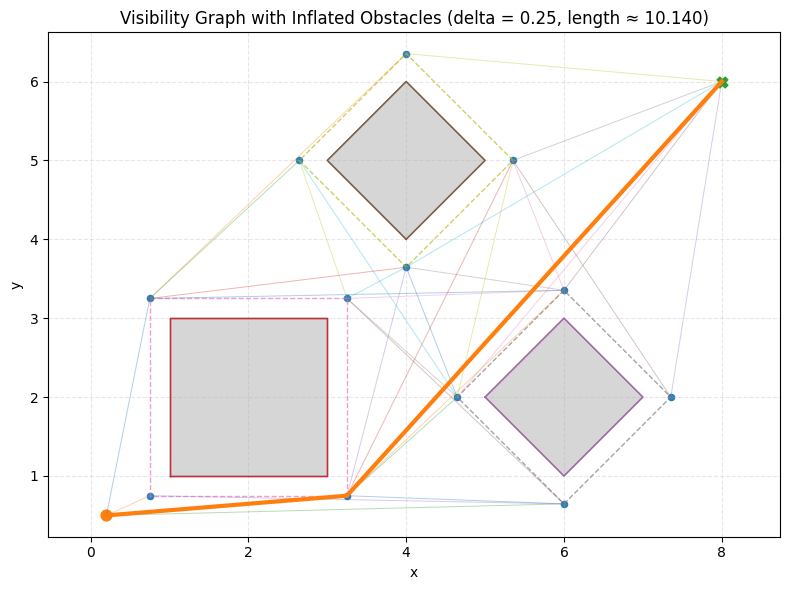

In [21]:
# Improved version: add `delta` to inflate convex polygonal obstacles via offsetting
# each supporting line outward by distance `delta` (Minkowski sum with a disk,
# for convex polygons). The visibility graph is built against the inflated obstacles.
#
# Implementation notes:
# - Works for CONVEX polygons given in order (cw or ccw).
# - Inflation uses parallel offset lines and intersects consecutive pairs.
# - We plot original and inflated obstacles; the graph/path use the inflated ones.
#
# No explicit colors/styles are set (per tool rules).

import math
import heapq
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

Point = Tuple[float, float]
Polygon = List[Point]

EPS = 1e-9

# ----------------------------
# Basic geometry helpers
# ----------------------------
def polygon_area(poly: Polygon) -> float:
    area2 = 0.0
    n = len(poly)
    for i in range(n):
        x1, y1 = poly[i]
        x2, y2 = poly[(i + 1) % n]
        area2 += x1 * y2 - x2 * y1
    return 0.5 * area2

def points_equal(p: Point, q: Point, eps: float = EPS) -> bool:
    return abs(p[0] - q[0]) <= eps and abs(p[1] - q[1]) <= eps

def orient(a: Point, b: Point, c: Point) -> float:
    return (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])

def on_segment(a: Point, b: Point, c: Point) -> bool:
    return (min(a[0], c[0]) - EPS <= b[0] <= max(a[0], c[0]) + EPS and
            min(a[1], c[1]) - EPS <= b[1] <= max(a[1], c[1]) + EPS)

def point_in_polygon(pt: Point, poly: Polygon) -> bool:
    x, y = pt
    inside = False
    n = len(poly)
    for i in range(n):
        x1, y1 = poly[i]
        x2, y2 = poly[(i + 1) % n]
        if ((y1 <= y < y2) or (y2 <= y < y1)):
            x_intersect = x1 + (y - y1) * (x2 - x1) / (y2 - y1 + 1e-20)
            if x_intersect >= x - EPS:
                inside = not inside
        if abs(orient((x1, y1), (x2, y2), (x, y))) <= EPS and on_segment((x1, y1), (x, y), (x2, y2)):
            return True
    return inside

def cross(u: Point, v: Point) -> float:
    return u[0]*v[1] - u[1]*v[0]

def line_intersection(P: Point, r: Point, Q: Point, s: Point):
    """Return intersection point of lines P + t r and Q + u s, assuming they are not parallel."""
    denom = cross(r, s)
    if abs(denom) < 1e-12:
        return None  # parallel; shouldn't happen for convex polygons with proper input
    t = cross((Q[0]-P[0], Q[1]-P[1]), s) / denom
    return (P[0] + t*r[0], P[1] + t*r[1])

# ----------------------------
# Inflate convex polygon by delta (parallel offset of supporting lines)
# ----------------------------
def inflate_convex_polygon(poly: Polygon, delta: float) -> Polygon:
    """
    Inflate (offset outward) a convex polygon by distance `delta`.
    The polygon may be cw or ccw and should be convex.
    """
    n = len(poly)
    if n < 3 or delta <= 0:
        return poly[:]
    area = polygon_area(poly)
    ccw = area > 0

    # For each edge, compute outward unit normal and offset line
    lines = []  # list of (point_on_line, direction)
    for i in range(n):
        p = poly[i]
        q = poly[(i + 1) % n]
        e = (q[0]-p[0], q[1]-p[1])
        elen = math.hypot(e[0], e[1])
        if elen < 1e-12:
            continue
        # left normal = (-ey, ex); for CCW polygons, interior is left;
        # outward is opposite of left normal; for CW, outward is left normal.
        if ccw:
            outward = ( e[1]/elen, -e[0]/elen)
        else:
            outward = (-e[1]/elen,  e[0]/elen)
        # Shift the line by delta along outward normal
        p_shift = (p[0] + outward[0]*delta, p[1] + outward[1]*delta)
        q_shift = (q[0] + outward[0]*delta, q[1] + outward[1]*delta)
        r = (q_shift[0]-p_shift[0], q_shift[1]-p_shift[1])  # same direction as original
        lines.append((p_shift, r))

    # New vertices: intersections of consecutive offset lines
    inflated = []
    for i in range(n):
        P, r = lines[i]
        Q, s = lines[(i + 1) % n]
        inter = line_intersection(P, r, Q, s)
        if inter is None:
            # Fallback: use shifted vertex (rare/degenerate)
            inter = P
        inflated.append(inter)
    return inflated

# ----------------------------
# Segment/obstacle intersection tests (as before)
# ----------------------------
def segments_intersect_strict(p1: Point, p2: Point, q1: Point, q2: Point) -> bool:
    if points_equal(p1, q1) or points_equal(p1, q2) or points_equal(p2, q1) or points_equal(p2, q2):
        return False
    o1 = orient(p1, p2, q1)
    o2 = orient(p1, p2, q2)
    o3 = orient(q1, q2, p1)
    o4 = orient(q1, q2, p2)
    if (o1 * o2 < 0) and (o3 * o4 < 0):
        return True
    if abs(o1) <= EPS and on_segment(p1, q1, p2):
        if not (points_equal(q1, p1) or points_equal(q1, p2) or points_equal(q1, q2)):
            return True
    if abs(o2) <= EPS and on_segment(p1, q2, p2):
        if not (points_equal(q2, p1) or points_equal(q2, p2) or points_equal(q1, q2)):
            return True
    if abs(o3) <= EPS and on_segment(q1, p1, q2):
        if not (points_equal(p1, q1) or points_equal(p1, q2) or points_equal(p1, p2)):
            return True
    if abs(o4) <= EPS and on_segment(q1, p2, q2):
        if not (points_equal(p2, q1) or points_equal(p2, q2) or points_equal(p1, p2)):
            return True
    return False

def segment_is_free(p: Point, q: Point, obstacles: List[Polygon]) -> bool:
    mid = ((p[0] + q[0]) * 0.5, (p[1] + q[1]) * 0.5)
    for poly in obstacles:
        if point_in_polygon(mid, poly):
            return False
        m = len(poly)
        for i in range(m):
            a = poly[i]
            b = poly[(i + 1) % m]
            if segments_intersect_strict(p, q, a, b):
                return False
    return True

# ----------------------------
# Visibility graph
# ----------------------------
def build_visibility_graph(start: Point, goal: Point, obstacles: List[Polygon], include_vertices=True):
    nodes: List[Point] = [start, goal]
    if include_vertices:
        for poly in obstacles:
            nodes.extend(poly)
    # Deduplicate
    unique_nodes = []
    for p in nodes:
        if not any(points_equal(p, q) for q in unique_nodes):
            unique_nodes.append(p)
    nodes = unique_nodes

    edges = []
    n = len(nodes)
    for i in range(n):
        for j in range(i + 1, n):
            p, q = nodes[i], nodes[j]
            if segment_is_free(p, q, obstacles):
                dist = math.hypot(p[0] - q[0], p[1] - q[1])
                edges.append((i, j, dist))
    return nodes, edges

def dijkstra(nodes: List[Point], edges: List[Tuple[int, int, float]], src: int, dst: int):
    adj = [[] for _ in range(len(nodes))]
    for i, j, w in edges:
        adj[i].append((j, w))
        adj[j].append((i, w))
    dist = [math.inf] * len(nodes)
    prev = [-1] * len(nodes)
    dist[src] = 0.0
    pq = [(0.0, src)]
    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u]:
            continue
        if u == dst:
            break
        for v, w in adj[u]:
            nd = d + w
            if nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))
    path_idx = []
    u = dst
    if dist[dst] < math.inf:
        while u != -1:
            path_idx.append(u)
            u = prev[u]
        path_idx.reverse()
    return path_idx, dist[dst]

# ----------------------------
# Example with delta inflation
# ----------------------------
obstacles: List[Polygon] = [
    [(1.0, 1.0), (3.0, 1.0), (3.0, 3.0), (1.0, 3.0)],     # square (convex)
    [(5.0, 2.0), (6.0, 1.0), (7.0, 2.0), (6.0, 3.0)],     # diamond (convex)
    [(4.0, 4.0), (5.0, 5.0), (4.0, 6.0), (3.0, 5.0)],     # diamond (convex)
]

start: Point = (0.2, 0.5)
goal:  Point = (8.0, 6.0)

delta = 0.25  # try different values (e.g., 0.0, 0.25, 0.5)

inflated_obstacles = [inflate_convex_polygon(poly, delta) for poly in obstacles]

# Build visibility graph using inflated obstacles
nodes, edges = build_visibility_graph(start, goal, inflated_obstacles, include_vertices=True)
src = nodes.index(start)
dst = nodes.index(goal)
path_idx, total_len = dijkstra(nodes, edges, src, dst)
path_coords = [nodes[i] for i in path_idx]

# ----------------------------
# Plot: original vs. inflated + graph + path
# ----------------------------
plt.figure(figsize=(8, 6))

# Original obstacles (thin)
for poly in obstacles:
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1, alpha=0.7)  # dashed for reference
    
# Plot inflated obstacles with gray fill
for poly in obstacles:
    xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
    plt.fill(xs, ys, alpha=0.4, color='0.6')  # gray fill
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1)  # outline
    
# Inflated obstacles (thicker, used for graph)
for poly in inflated_obstacles:
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1, alpha=0.7, linestyle='--')

# Visibility graph edges
for i, j, _ in edges:
    x1, y1 = nodes[i]; x2, y2 = nodes[j]
    plt.plot([x1, x2], [y1, y2], linewidth=0.7, alpha=0.35)

# Nodes
xs = [p[0] for p in nodes]; ys = [p[1] for p in nodes]
plt.scatter(xs, ys, s=20, alpha=0.9)

# Start/goal
plt.scatter([start[0]], [start[1]], s=60, marker='o')
plt.scatter([goal[0]], [goal[1]], s=60, marker='X')

# Final path
if len(path_coords) >= 2:
    px = [p[0] for p in path_coords]; py = [p[1] for p in path_coords]
    plt.plot(px, py, linewidth=3)

plt.title(f"Visibility Graph with Inflated Obstacles (delta = {delta}, length ≈ {total_len:.3f})")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


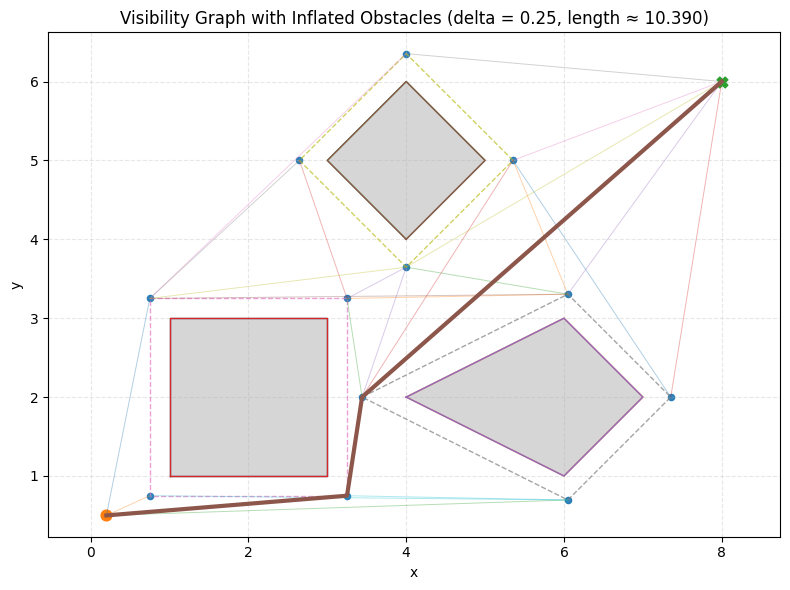

In [7]:
# ----------------------------
# Example with delta inflation
# ----------------------------
obstacles: List[Polygon] = [
    [(1.0, 1.0), (3.0, 1.0), (3.0, 3.0), (1.0, 3.0)],     # square (convex)
    [(4.0, 2.0), (6.0, 1.0), (7.0, 2.0), (6.0, 3.0)],     # diamond (convex)
    [(4.0, 4.0), (5.0, 5.0), (4.0, 6.0), (3.0, 5.0)],     # diamond (convex)
]

start: Point = (0.2, 0.5)
goal:  Point = (8.0, 6.0)

delta = 0.25  # try different values (e.g., 0.0, 0.25, 0.5)

inflated_obstacles = [inflate_convex_polygon(poly, delta) for poly in obstacles]

# Build visibility graph using inflated obstacles
nodes, edges = build_visibility_graph(start, goal, inflated_obstacles, include_vertices=True)
src = nodes.index(start)
dst = nodes.index(goal)
path_idx, total_len = dijkstra(nodes, edges, src, dst)
path_coords = [nodes[i] for i in path_idx]

# ----------------------------
# Plot: original vs. inflated + graph + path
# ----------------------------
plt.figure(figsize=(8, 6))

# Original obstacles (thin)
for poly in obstacles:
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1, alpha=0.7)  # dashed for reference
    
# Plot inflated obstacles with gray fill
for poly in obstacles:
    xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
    plt.fill(xs, ys, alpha=0.4, color='0.6')  # gray fill
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1)  # outline
    
# Inflated obstacles (thicker, used for graph)
for poly in inflated_obstacles:
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1, alpha=0.7, linestyle='--')

# Visibility graph edges
for i, j, _ in edges:
    x1, y1 = nodes[i]; x2, y2 = nodes[j]
    plt.plot([x1, x2], [y1, y2], linewidth=0.7, alpha=0.35)

# Nodes
xs = [p[0] for p in nodes]; ys = [p[1] for p in nodes]
plt.scatter(xs, ys, s=20, alpha=0.9)

# Start/goal
plt.scatter([start[0]], [start[1]], s=60, marker='o')
plt.scatter([goal[0]], [goal[1]], s=60, marker='X')

# Final path
if len(path_coords) >= 2:
    px = [p[0] for p in path_coords]; py = [p[1] for p in path_coords]
    plt.plot(px, py, linewidth=3)

plt.title(f"Visibility Graph with Inflated Obstacles (delta = {delta}, length ≈ {total_len:.3f})")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


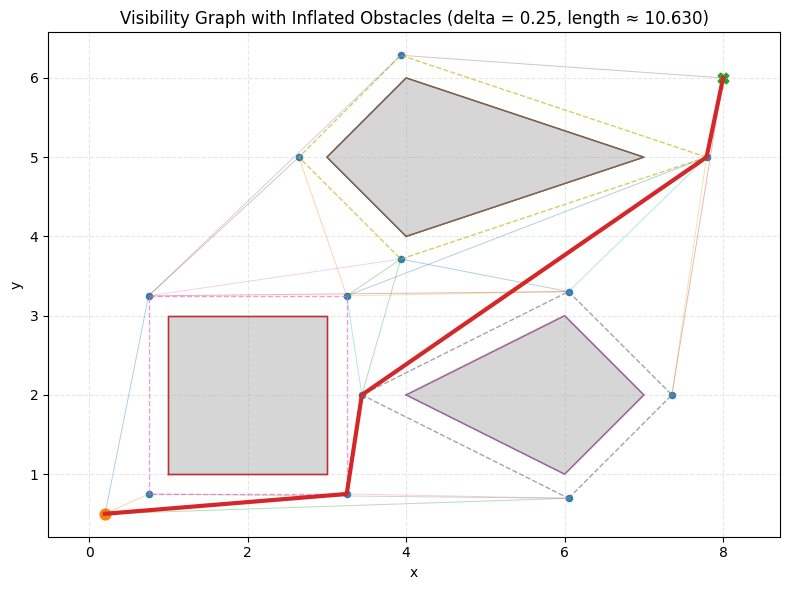

In [8]:
# ----------------------------
# Example with delta inflation
# ----------------------------
obstacles: List[Polygon] = [
    [(1.0, 1.0), (3.0, 1.0), (3.0, 3.0), (1.0, 3.0)],     # square (convex)
    [(4.0, 2.0), (6.0, 1.0), (7.0, 2.0), (6.0, 3.0)],     # diamond (convex)
    [(4.0, 4.0), (7.0, 5.0), (4.0, 6.0), (3.0, 5.0)],     # diamond (convex)
]

start: Point = (0.2, 0.5)
goal:  Point = (8.0, 6.0)

delta = 0.25  # try different values (e.g., 0.0, 0.25, 0.5)

inflated_obstacles = [inflate_convex_polygon(poly, delta) for poly in obstacles]

# Build visibility graph using inflated obstacles
nodes, edges = build_visibility_graph(start, goal, inflated_obstacles, include_vertices=True)
src = nodes.index(start)
dst = nodes.index(goal)
path_idx, total_len = dijkstra(nodes, edges, src, dst)
path_coords = [nodes[i] for i in path_idx]

# ----------------------------
# Plot: original vs. inflated + graph + path
# ----------------------------
plt.figure(figsize=(8, 6))

# Original obstacles (thin)
for poly in obstacles:
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1, alpha=0.7)  # dashed for reference
    
# Plot inflated obstacles with gray fill
for poly in obstacles:
    xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
    plt.fill(xs, ys, alpha=0.4, color='0.6')  # gray fill
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1)  # outline
    
# Inflated obstacles (thicker, used for graph)
for poly in inflated_obstacles:
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1, alpha=0.7, linestyle='--')

# Visibility graph edges
for i, j, _ in edges:
    x1, y1 = nodes[i]; x2, y2 = nodes[j]
    plt.plot([x1, x2], [y1, y2], linewidth=0.7, alpha=0.35)

# Nodes
xs = [p[0] for p in nodes]; ys = [p[1] for p in nodes]
plt.scatter(xs, ys, s=20, alpha=0.9)

# Start/goal
plt.scatter([start[0]], [start[1]], s=60, marker='o')
plt.scatter([goal[0]], [goal[1]], s=60, marker='X')

# Final path
if len(path_coords) >= 2:
    px = [p[0] for p in path_coords]; py = [p[1] for p in path_coords]
    plt.plot(px, py, linewidth=3)

plt.title(f"Visibility Graph with Inflated Obstacles (delta = {delta}, length ≈ {total_len:.3f})")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()


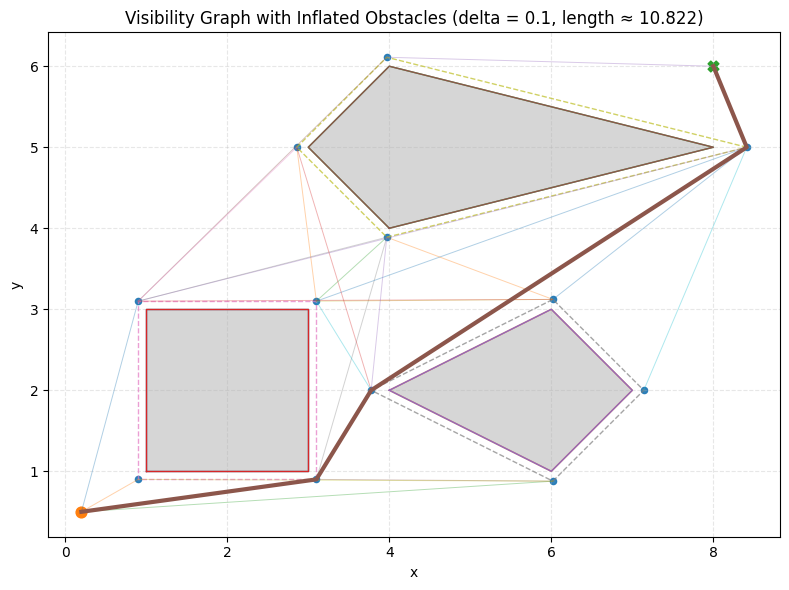

In [18]:
# ----------------------------
# Example with delta inflation
# ----------------------------
obstacles: List[Polygon] = [
    [(1.0, 1.0), (3.0, 1.0), (3.0, 3.0), (1.0, 3.0)],     # square (convex)
    [(4.0, 2.0), (6.0, 1.0), (7.0, 2.0), (6.0, 3.0)],     # diamond (convex)
    [(4.0, 4.0), (8.0, 5.0), (4.0, 6.0), (3.0, 5.0)],     # diamond (convex)
]

start: Point = (0.2, 0.5)
goal:  Point = (8.0, 6.0)

delta = 0.1  # try different values (e.g., 0.0, 0.25, 0.5)

inflated_obstacles = [inflate_convex_polygon(poly, delta) for poly in obstacles]

# Build visibility graph using inflated obstacles
nodes, edges = build_visibility_graph(start, goal, inflated_obstacles, include_vertices=True)
src = nodes.index(start)
dst = nodes.index(goal)
path_idx, total_len = dijkstra(nodes, edges, src, dst)
path_coords = [nodes[i] for i in path_idx]

# ----------------------------
# Plot: original vs. inflated + graph + path
# ----------------------------
plt.figure(figsize=(8, 6))

# Original obstacles (thin)
for poly in obstacles:
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1, alpha=0.7)  # dashed for reference
    
# Plot inflated obstacles with gray fill
for poly in obstacles:
    xs = [p[0] for p in poly]; ys = [p[1] for p in poly]
    plt.fill(xs, ys, alpha=0.4, color='0.6')  # gray fill
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1)  # outline
    
# Inflated obstacles (thicker, used for graph)
for poly in inflated_obstacles:
    c = poly + [poly[0]]
    xs = [p[0] for p in c]; ys = [p[1] for p in c]
    plt.plot(xs, ys, linewidth=1, alpha=0.7, linestyle='--')

# Visibility graph edges
for i, j, _ in edges:
    x1, y1 = nodes[i]; x2, y2 = nodes[j]
    plt.plot([x1, x2], [y1, y2], linewidth=0.7, alpha=0.35)

# Nodes
xs = [p[0] for p in nodes]; ys = [p[1] for p in nodes]
plt.scatter(xs, ys, s=20, alpha=0.9)

# Start/goal
plt.scatter([start[0]], [start[1]], s=60, marker='o')
plt.scatter([goal[0]], [goal[1]], s=60, marker='X')

# Final path
if len(path_coords) >= 2:
    px = [p[0] for p in path_coords]; py = [p[1] for p in path_coords]
    plt.plot(px, py, linewidth=3)

plt.title(f"Visibility Graph with Inflated Obstacles (delta = {delta}, length ≈ {total_len:.3f})")
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.3)
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()
